In [571]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from scipy.sparse import csr_matrix

import torch
# from torch.utils.data import Dataset, DataLoader
# import torch.optim as optim
import torch.nn as nn
# import torch.nn.functional as F
# from torchvision import models

In [572]:
# get train data from CSV
df_train = pd.read_csv('cs480-spring2020/train.csv').fillna(' ')
# df_train.dtypes
df_train['label'].value_counts()

0    8496
3    7524
4    5523
2     381
5      23
1       1
Name: label, dtype: int64

### Preprocessing - Label Encoding for Category + Datetime + Description Text Noise Removal

In [550]:
# category one hot encoding
df_train['category'] = df_train['category'].astype('category')
df_train['category'] = df_train['category'].cat.codes

# datetime columns
df_train['published'] = pd.to_datetime(df_train['published'], 
 format = '%Y-%m-%dT%H:%M:%SZ', 
 errors = 'coerce')
df_train['modified'] = pd.to_datetime(df_train['modified'], 
 format = '%Y-%m-%dT%H:%M:%SZ', 
 errors = 'coerce')

df_train['published_year'] = df_train['published'].dt.year
df_train['published_month'] = df_train['published'].dt.month
df_train['published_week'] = df_train['published'].dt.week
df_train['published_day'] = df_train['published'].dt.day
df_train['published_hour'] = df_train['published'].dt.hour
df_train['published_minute'] = df_train['published'].dt.minute
df_train['published_dayofweek'] = df_train['published'].dt.dayofweek

df_train['modified_year'] = df_train['modified'].dt.year
df_train['modified_month'] = df_train['modified'].dt.month
df_train['modified_week'] = df_train['modified'].dt.week
df_train['modified_day'] = df_train['modified'].dt.day
df_train['modified_hour'] = df_train['modified'].dt.hour
df_train['modified_minute'] = df_train['modified'].dt.minute
df_train['modified_dayofweek'] = df_train['modified'].dt.dayofweek

# Noise Removal
df_train['description'] = df_train['description'].str.replace('[^a-zA-Z\s]', '')


# X = df_train[['competition-num', 'num-comments','version', 'category', 
#         'published_year', 'published_month', 'published_week', 'published_day', 'published_hour', 'published_minute', 'published_dayofweek',
#         'modified_year', 'modified_month', 'modified_week', 'modified_day', 'modified_hour', 'modified_minute', 'modified_dayofweek',
#        'feedback-karma', 'ratings-given', 'ratings-received','num-authors', 'prev-games', 'fun-average',
#        'innovation-average', 'theme-average', 'graphics-average',
#        'audio-average', 'humor-average', 'mood-average', 'fun-rank',
#        'innovation-rank', 'theme-rank', 'graphics-rank', 'audio-rank',
#        'humor-rank', 'mood-rank']]  # Features
# y = df_train['label']  # Labels



# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test
# df_train = pd.concat([X_train, y_train], axis=1)
# df_test = pd.concat([X_test, y_test], axis=1)

# num_test = len(df_test)
# df_train.head()

### Data Augmentation - Only on df_train

In [341]:
# resample label = 1 6 times because there's only 1 entry
label_1 = df_train[df_train.label==1]

# upsample minority
label_1_upsampled = resample(label_1,
                          replace=True, # sample with replacement
                          n_samples=6) # match number in majority class

df_train = pd.concat([df_train, label_1_upsampled])

In [342]:
X_train = df_train[['competition-num', 'num-comments','version', 'category',
        'published_year', 'published_month', 'published_week', 'published_day', 'published_hour', 'published_minute', 'published_dayofweek',
        'modified_year', 'modified_month', 'modified_week', 'modified_day', 'modified_hour', 'modified_minute', 'modified_dayofweek',
       'feedback-karma', 'ratings-given', 'ratings-received','num-authors', 'prev-games', 'fun-average',
       'innovation-average', 'theme-average', 'graphics-average',
       'audio-average', 'humor-average', 'mood-average', 'fun-rank',
       'innovation-rank', 'theme-rank', 'graphics-rank', 'audio-rank',
       'humor-rank', 'mood-rank']]  # Features
y_train = df_train['label']  # Labels

In [343]:
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
y_train.value_counts()

5    6013
4    6013
3    6013
2    6013
1    6013
0    6013
Name: label, dtype: int64

In [344]:
df_train = pd.concat([X_train, y_train], axis=1)
df_train = shuffle(df_train).reset_index()

df_train = pd.concat([df_train, df_test]) # Add them back together

### Separating the columns into 'Categorical', 'Numerical' and 'Output'

In [551]:
categorical_columns = ['category']
numerical_columns = ['competition-num', 'num-comments','version',
       'published_year', 'published_month', 'published_week', 'published_day', 'published_hour', 'published_minute', 'published_dayofweek',
        'modified_year', 'modified_month', 'modified_week', 'modified_day', 'modified_hour', 'modified_minute', 'modified_dayofweek',
        'feedback-karma', 'ratings-given', 'ratings-received','num-authors', 'prev-games', 'fun-average',
       'innovation-average', 'theme-average', 'graphics-average',
       'audio-average', 'humor-average', 'mood-average', 'fun-rank',
       'innovation-rank', 'theme-rank', 'graphics-rank', 'audio-rank',
       'humor-rank', 'mood-rank']
outputs = ['label']

In [552]:
for category in categorical_columns:
    df_train[category] = df_train[category].astype('category')

In [553]:
# df_train.dtypes

## Converting columns to Tensors

#### Categorical

In [554]:
category = df_train['category'].cat.codes.values
# pub = df_train['published'].cat.codes.values
categorical_data = np.stack([category], 1)
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)
categorical_data[:5]

tensor([[1],
        [0],
        [1],
        [1],
        [0]])

#### Numerical

In [555]:
numerical_data = np.stack([df_train[col].values for col in numerical_columns], 1)
numerical_data = torch.tensor(numerical_data, dtype=torch.float)
numerical_data[:1]

tensor([[ 3.8000e+01,  1.7000e+01,  7.3140e+04,  2.0170e+03,  4.0000e+00,
          1.7000e+01,  2.5000e+01,  1.0000e+00,  1.0000e+00,  1.0000e+00,
          2.0170e+03,  5.0000e+00,  1.8000e+01,  1.0000e+00,  6.0000e+00,
          3.5000e+01,  0.0000e+00,  1.9000e+01,  5.2125e+01,  2.6571e+01,
          5.0000e+00,  0.0000e+00,  3.8400e+00,  3.2800e+00,  3.7200e+00,
          3.6800e+00, -1.0000e+00,  4.0000e+00,  3.6090e+00,  8.8000e+01,
          2.9800e+02,  2.3000e+02,  3.2800e+02, -1.0000e+00,  3.8000e+01,
          2.0200e+02]])

#### Output

In [556]:
# df_train['label'] = df_train['label'].astype('category')
outputs = torch.tensor(df_train[outputs].values).flatten()
outputs[:5]

tensor([4, 4, 4, 4, 3])

In [557]:
print(categorical_data.shape)
print(numerical_data.shape)
print(outputs.shape)

torch.Size([21948, 1])
torch.Size([21948, 36])
torch.Size([21948])


### Categorical Embedding

In [558]:
categorical_column_sizes = [len(df_train[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]
print(categorical_embedding_sizes)

[(2, 1)]


## Train Test Split

In [559]:
total_records = len(df_train)
test_records = int(total_records*0.3)
# test_records = 0

categorical_train_data = categorical_data[:total_records-test_records]
categorical_test_data = categorical_data[total_records-test_records:total_records]
numerical_train_data = numerical_data[:total_records-test_records]
numerical_test_data = numerical_data[total_records-test_records:total_records]
train_outputs = outputs[:total_records-test_records]
test_outputs = outputs[total_records-test_records:total_records]

In [560]:
print(len(categorical_train_data))
print(len(numerical_train_data))
print(len(train_outputs))

print(len(categorical_test_data))
print(len(numerical_test_data))
print(len(test_outputs))

15364
15364
15364
6584
6584
6584


## Neural Network Model

In [561]:
class Model(nn.Module):

    def __init__(self, embedding_size, num_numerical_cols, output_size, layers, p=0.2):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols + num_numerical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical, x_numerical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        return x

In [562]:
# model = Model(categorical_embedding_sizes, numerical_data.shape[1], 6, [200,100,50], p=0.4)

model = Model(categorical_embedding_sizes, numerical_data.shape[1], 6, [10000,5000,2500,1000,500], p=0.2)

In [563]:
print(model)

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(2, 1)
  )
  (embedding_dropout): Dropout(p=0.2, inplace=False)
  (batch_norm_num): BatchNorm1d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=37, out_features=10000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(10000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=10000, out_features=5000, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(5000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=5000, out_features=2500, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(2500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=2500, out_features=1000, bias=True)
    (13): ReLU(inplac

## Optimizer

In [564]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train

In [565]:
epochs = 10
aggregated_losses = []

for i in range(epochs):
    i += 1
    y_pred = model(categorical_train_data, numerical_train_data)
#     print(y_pred)
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss)

#     if i%25 == 1:
    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 1.95255065
epoch:   2 loss: 0.85305005
epoch:   3 loss: 0.97538352
epoch:   4 loss: 0.40015364
epoch:   5 loss: 0.32195863
epoch:   5 loss: 0.3219586313


In [566]:
from matplotlib import pyplot as plt

Text(0.5,0,'epoch')

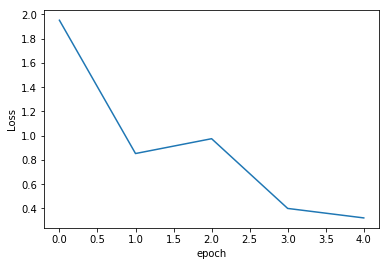

In [567]:
plt.plot(range(epochs), aggregated_losses)
plt.ylabel('Loss')
plt.xlabel('epoch')

## Predict - While Testing

In [568]:
with torch.no_grad():
    y_val = model(categorical_test_data, numerical_test_data)
    loss = loss_function(y_val, test_outputs)
print(f'Loss: {loss:.8f}')

Loss: 0.32718718


In [569]:
y_val = np.argmax(y_val, axis=1)

In [570]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(test_outputs,y_val, labels=[0,1,2,3,4,5]))
print(classification_report(test_outputs,y_val))
print(accuracy_score(test_outputs, y_val))

[[2634    0    0    0   12    0]
 [   0    0    0    0    0    0]
 [   1    0    0  100    0    0]
 [   2    0    0 1819  268    0]
 [   6    0    0  429 1304    0]
 [   0    0    0    0    9    0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2646
           2       0.00      0.00      0.00       101
           3       0.77      0.87      0.82      2089
           4       0.82      0.75      0.78      1739
           5       0.00      0.00      0.00         9

    accuracy                           0.87      6584
   macro avg       0.52      0.52      0.52      6584
weighted avg       0.86      0.87      0.87      6584

0.8743924665856622


/Users/taru/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# For Submission

In [479]:
# get train data from CSV
df_test = pd.read_csv('cs480-spring2020/test.csv').fillna(' ')

# category one hot encoding
df_test['category'] = df_test['category'].astype('category')
df_test['category'] = df_test['category'].cat.codes

# datetime columns
df_test['published'] = pd.to_datetime(df_test['published'], 
 format = '%Y-%m-%dT%H:%M:%SZ', 
 errors = 'coerce')
df_test['modified'] = pd.to_datetime(df_test['modified'], 
 format = '%Y-%m-%dT%H:%M:%SZ', 
 errors = 'coerce')


df_test['published_year'] = df_test['published'].dt.year
df_test['published_month'] = df_test['published'].dt.month
df_test['published_week'] = df_test['published'].dt.week
df_test['published_day'] = df_test['published'].dt.day
df_test['published_hour'] = df_test['published'].dt.hour
df_test['published_minute'] = df_test['published'].dt.minute
df_test['published_dayofweek'] = df_test['published'].dt.dayofweek

df_test['modified_year'] = df_test['modified'].dt.year
df_test['modified_month'] = df_test['modified'].dt.month
df_test['modified_week'] = df_test['modified'].dt.week
df_test['modified_day'] = df_test['modified'].dt.day
df_test['modified_hour'] = df_test['modified'].dt.hour
df_test['modified_minute'] = df_test['modified'].dt.minute
df_test['modified_dayofweek'] = df_test['modified'].dt.dayofweek

In [480]:
for category in categorical_columns:
    df_test[category] = df_test[category].astype('category')

In [481]:
category = df_test['category'].cat.codes.values
# pub = df_train['published'].cat.codes.values
categorical_test_data = np.stack([category], 1)
categorical_test_data = torch.tensor(categorical_test_data, dtype=torch.int64)
categorical_test_data[:5]

tensor([[0],
        [1],
        [1],
        [1],
        [0]])

In [482]:
numerical_test_data = np.stack([df_test[col].values for col in numerical_columns], 1)
numerical_test_data = torch.tensor(numerical_test_data, dtype=torch.float)
numerical_test_data[:1]

tensor([[ 4.6000e+01,  5.0000e+00,  6.4060e+05,  2.0200e+03,  5.0000e+00,
          2.0000e+01,  1.2000e+01,  1.9000e+01,  2.5000e+01,  1.0000e+00,
          2.0200e+03,  5.0000e+00,  2.0000e+01,  1.2000e+01,  1.9000e+01,
          2.5000e+01,  1.0000e+00,  9.0000e+00,  1.1500e+01,  5.0000e+00,
          1.0000e+00,  3.0000e+00,  4.0000e+00,  4.0000e+00,  4.3330e+00,
          3.8330e+00, -1.0000e+00,  3.0000e+00,  4.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00]])

In [483]:
# Predict

with torch.no_grad():
    y_val = model(categorical_test_data, numerical_test_data)
    
y_val = np.argmax(y_val, axis=1)

In [485]:
# create submission file to submit in Kaggle competition
submission = pd.DataFrame({'id': df_test['id'], 'label': y_val})
submission.to_csv('submission6.csv', index=False)
len(submission)

4959